In [20]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import mplhep as hep

from cycler import cycler
# import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'


def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

## Wcb Ana in resolved channel

In [21]:
# Load samples for resolved regime (updated 0214)
df0 = {}
df0["ttbarsl"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/TTbarSL_ntuple_id0-99.root", "/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/TTbarSL_ntuple_id100-999.root"])
df0["wjets"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/WJetsToLNuPlus2J_Delphes4J_ntuple_id0-199.root", "/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/WJetsToLNuPlus2J_Delphes4J_ntuple_id200-999.root"])
df0["wwsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/WWSL_ntuple_id0-99.root")
df0["twsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/TWSL_ntuple_id0-99.root")

df0["ttbarsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/TTbarSL_WToCB_ntuple_id0-24.root")
df0["twsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/TWSL_WToCB_ntuple_id0-24.root")
df0["wwsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_rsv/merged_ntuple/WWSL_WToCB_ntuple_id0-24.root")

# Note: do not apply any filter here! Just calculate the vars
for sam in df0:
    _df = df0[sam]
    # for ttbarsl and wjets: in the first file, only keep half the event (excluding the training events)
    if sam == 'ttbarsl':
        df0[sam]['keep_event'] = (ak.values_astype(np.tan(_df.lep_pt) * 100000, 'int') % 100 >= 50) | (ak.local_index(_df.lep_pt) >= 1410428)
    elif sam == 'wjets':
        df0[sam]['keep_event'] = (ak.values_astype(np.tan(_df.lep_pt) * 100000, 'int') % 100 >= 50) | (ak.local_index(_df.lep_pt) >= 2165296)
    else:
        df0[sam]['keep_event'] = (ak.values_astype(np.tan(_df.lep_pt) * 100000, 'int') % 100 >= 50)

# total lumi for Run2 + Run3
lumi_tot = 450 # fb-1

# compute weights from un-selected events
weights = {
    "ttbarsl": (lumi_tot / 100.) * 12710000 / len(df0["ttbarsl"]),
    "wjets": (lumi_tot / 100.) * 52300000 / len(df0["wjets"]), # number of events passing >=4 jet selection
    "wwsl": (lumi_tot / 100.) * 1615000 / len(df0["wwsl"]),
    "twsl": (lumi_tot / 100.) * 1108000 / len(df0["twsl"]),

    "ttbarsl_wcb": (lumi_tot / 100.) * 12710000 * 0.0008398 / len(df0["ttbarsl_wcb"]),
    "wwsl_wcb": (lumi_tot / 100.) * 1615000 * 0.0008398 / len(df0["wwsl_wcb"]),
    "twsl_wcb": (lumi_tot / 100.) * 1108000 * 0.0008398 / len(df0["twsl_wcb"]),
}
print({sam: len(df0[sam]) for sam in df0})
print(weights)


{'ttbarsl': 14103972, 'wjets': 10840067, 'wwsl': 2198372, 'twsl': 1803005, 'ttbarsl_wcb': 354549, 'twsl_wcb': 453551, 'wwsl_wcb': 551420}
{'ttbarsl': 4.05524060881573, 'wjets': 21.711120420196664, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'ttbarsl_wcb': 0.13547453525464748, 'wwsl_wcb': 0.01106823564614994, 'twsl_wcb': 0.00923213221886844}


In [22]:
ftag_wp = {"T_b1": 0.8493, "T_b2": 0.5881, "T_c1": 0.7574, "T_c2": 0.2963}

# new variables and selections
df = {}
for sam in df0:
    # requires:
    # - passing >=4 jet selection (analyzer has passed this cut)
    # - passing >=4 jet requiring pT > 25 GeV (new!!!)
    # - exactly one lepton
    df[sam] = df0[sam][(ak.num(df0[sam].jet_pt[df0[sam].jet_pt > 25]) >= 4) & (df0[sam].n_el + df0[sam].n_mu == 1)]
    d = df[sam]

    # jet flavour tagging
    df[sam]["jet_ftag_B1"] = d.jet_sophonAK4_probB > ftag_wp["T_b1"]
    df[sam]["jet_ftag_B2"] = (d.jet_sophonAK4_probB > ftag_wp["T_b2"]) & ~d.jet_ftag_B1
    df[sam]["jet_ftag_C1"] = (d.jet_sophonAK4_probC > ftag_wp["T_c1"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2
    df[sam]["jet_ftag_C2"] = (d.jet_sophonAK4_probC > ftag_wp["T_c2"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1
    df[sam]["jet_ftag_N"] = ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1 & ~d.jet_ftag_C2

    # obj p4
    df[sam]["jet_p4"] = _p4_from_ptetaphie(d.jet_pt, d.jet_eta, d.jet_phi, d.jet_energy)
    df[sam]["lep_p4"] = _p4_from_ptetaphie(d.lep_pt, d.lep_eta, d.lep_phi, d.lep_energy)
    zeros = ak.zeros_like(d.lep_pt)
    df[sam]["met_p4"] = _p4_from_ptetaphim(d.met_pt, zeros, d.met_phi, zeros) # note: this is ptetaphim!

    ## clean jets (non overlapping with fjcand and lep), and pt > 25 (new!!!)
    cleanjet_flag = (d.jet_p4.deltaR(d.lep_p4) > 0.4) & (d.jet_pt > 25)
    df[sam]["cleanjet_p4"] = d.jet_p4[cleanjet_flag]

    ## concatenate all objects
    df[sam]["obj_pt"] = ak.concatenate([ak.singletons(d.lep_pt), ak.singletons(d.met_pt), d.jet_pt[cleanjet_flag]], axis=1)
    df[sam]["obj_pt_log"] = np.log(d.obj_pt)
    df[sam]["obj_energy"] = ak.concatenate([ak.singletons(d.lep_energy), ak.singletons(d.met_pt), d.jet_energy[cleanjet_flag]], axis=1)
    df[sam]["obj_energy_log"] = np.log(d.obj_energy)
    df[sam]["obj_eta"] = ak.concatenate([ak.singletons(d.lep_eta), ak.singletons(ak.zeros_like(d.met_pt)), d.jet_eta[cleanjet_flag]], axis=1)
    df[sam]["obj_px"] = ak.concatenate([ak.singletons(d.lep_px), ak.singletons(d.met_pt * np.cos(d.met_phi)), d.jet_px[cleanjet_flag]], axis=1)
    df[sam]["obj_py"] = ak.concatenate([ak.singletons(d.lep_py), ak.singletons(d.met_pt * np.sin(d.met_phi)), d.jet_py[cleanjet_flag]], axis=1)
    df[sam]["obj_pz"] = ak.concatenate([ak.singletons(d.lep_pz), ak.singletons(ak.zeros_like(d.met_pt)), d.jet_pz[cleanjet_flag]], axis=1)

    # flags
    lep_zeros = ak.zeros_like(ak.singletons(d.lep_pt), dtype=bool)
    met_zeros = ak.zeros_like(ak.singletons(d.met_pt), dtype=bool)
    cleanjet_zeros = ak.zeros_like(d.jet_pt[cleanjet_flag], dtype=bool)

    df[sam]["obj_is_lep"] = ak.concatenate([~lep_zeros, met_zeros, cleanjet_zeros], axis=1)
    df[sam]["obj_is_met"] = ak.concatenate([lep_zeros, ~met_zeros, cleanjet_zeros], axis=1)
    df[sam]["obj_is_cleanjet"] = ak.concatenate([lep_zeros, met_zeros, ~cleanjet_zeros], axis=1)
    df[sam]["obj_is_cleanjet_ftag_B1"] = ak.concatenate([lep_zeros, met_zeros, d.jet_ftag_B1[cleanjet_flag]], axis=1)
    df[sam]["obj_is_cleanjet_ftag_B2"] = ak.concatenate([lep_zeros, met_zeros, d.jet_ftag_B2[cleanjet_flag]], axis=1)
    df[sam]["obj_is_cleanjet_ftag_C1"] = ak.concatenate([lep_zeros, met_zeros, d.jet_ftag_C1[cleanjet_flag]], axis=1)
    df[sam]["obj_is_cleanjet_ftag_C2"] = ak.concatenate([lep_zeros, met_zeros, d.jet_ftag_C2[cleanjet_flag]], axis=1)
    df[sam]["obj_is_cleanjet_ftag_N"] = ak.concatenate([lep_zeros, met_zeros, d.jet_ftag_N[cleanjet_flag]], axis=1)

    # auxilliary: sophon scores
    df[sam]["obj_sophon_probB"] = ak.concatenate([lep_zeros, met_zeros, d.jet_sophonAK4_probB[cleanjet_flag]], axis=1)
    df[sam]["obj_sophon_probC"] = ak.concatenate([lep_zeros, met_zeros, d.jet_sophonAK4_probC[cleanjet_flag]], axis=1)
    df[sam]["obj_sophon_probB_log"] = np.log(np.maximum(d.obj_sophon_probB, 1e-10))
    df[sam]["obj_sophon_probC_log"] = np.log(np.maximum(d.obj_sophon_probC, 1e-10))

    df[sam]["obj_mask"] = ak.ones_like(d.obj_pt, dtype=bool)

    # truth labels
    for n in ['ttbarsl', 'wjets', 'wwsl', 'twsl', 'ttbarsl_wcb', 'twsl_wcb', 'wwsl_wcb']:
        df[sam][f"is_{n}"] = np.zeros(len(d), dtype=bool) + (sam == n)

print({sam: len(df[sam]) for sam in df})
print(weights)

# without pT>25 requirement for 4 jets
# {'ttbarsl': 8946826, 'wjets': 3484878, 'wwsl': 211661, 'twsl': 708880, 'ttbarsl_wcb': 218322, 'twsl_wcb': 171258, 'wwsl_wcb': 49814}
# {'ttbarsl': 4.05524060881573, 'wjets': 21.711120420196664, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'ttbarsl_wcb': 0.13547453525464748, 'wwsl_wcb': 0.01106823564614994, 'twsl_wcb': 0.00923213221886844}

{'ttbarsl': 8745822, 'wjets': 3149122, 'wwsl': 194285, 'twsl': 679350, 'ttbarsl_wcb': 212957, 'twsl_wcb': 163689, 'wwsl_wcb': 45721}
{'ttbarsl': 4.05524060881573, 'wjets': 21.711120420196664, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'ttbarsl_wcb': 0.13547453525464748, 'wwsl_wcb': 0.01106823564614994, 'twsl_wcb': 0.00923213221886844}


In [4]:
## custom: to estimate the MET pz from W mass equation

# for sam in df:
#     d = df[sam]

#     def _get_met_pz(_df):
#         # formula: 
#         # (C pzl + m2 pzl - Sqrt[
#         #  C^2 El^2 + 2 C El^2 m2 + El^2 m2^2 - El^4 ptm^2 + 
#         #   El^2 ptm^2 pzl^2])/(El^2 - pzl^2)
#         El = _df.lep_energy
#         pzl = _df.lep_pz
#         ptm = _df.met_pt
#         m2 = 80.379**2 / 2
#         C = _df.lep_pt * _df.met_pt * np.cos(_df.lep_phi - _df.met_phi)
#         delta = np.maximum(C**2 * El**2 + 2 * C * El**2 * m2 + El**2 * m2**2 - El**4 * ptm**2 + El**2 * ptm**2 * pzl**2,  0)
#         return (C * pzl + m2 * pzl - np.sqrt(delta)) / (El**2 - pzl**2), (C * pzl + m2 * pzl + np.sqrt(delta)) / (El**2 - pzl**2)

#     df[sam]["met_pz1"], df[sam]["met_pz2"] = _get_met_pz(d)
#     df[sam]["metm1_p4"] = _p4_from_ptetaphim(d.met_pt, 0.5 * np.log(np.maximum(1 + (2 * d.met_pz1) / np.maximum(np.sqrt(d.met_pt**2 + d.met_pz1**2) - d.met_pz1, 1e-8), 1e-8)), d.met_phi, np.zeros(len(d))) # note: this is ptetaphim!
#     df[sam]["metm2_p4"] = _p4_from_ptetaphim(d.met_pt, 0.5 * np.log(np.maximum(1 + (2 * d.met_pz2) / np.maximum(np.sqrt(d.met_pt**2 + d.met_pz2**2) - d.met_pz2, 1e-8), 1e-8)), d.met_phi, np.zeros(len(d))) # note: this is ptetaphim!

#     df[sam]["blep_cand_idx"] = ak.argmin(np.abs((d.metm1_p4.phi - d.cleanjet_p4.phi + np.pi) % (2 * np.pi) - np.pi), axis=1)
#     df[sam]["blep_cand_p4"] = d.cleanjet_p4[ak.singletons(d.blep_cand_idx)][:, 0]

In [23]:
for sam in df0:
    # load DNN scores
    # _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_resolved_evtobj.noweights.nobj8/v2/pred_{sam}.root')
    _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_resolved_evtobj.noweights.nobj8.pt25/v2/pred_{sam}.root') # new DNN model; with pT>25 selection
    for b in ["score_is_ttbarsl", "score_is_wjets", "score_is_wwsl", "score_is_twsl", "score_is_ttbarsl_wcb", "score_is_twsl_wcb", "score_is_wwsl_wcb"]:
        df[sam][b] = _df[b]
    df[sam]["evt_dnn_score"] = ak.numexpr.evaluate("(score_is_ttbarsl_wcb + 0.068*score_is_twsl_wcb + 0.08*score_is_wwsl_wcb) / (score_is_ttbarsl_wcb + 0.068*score_is_twsl_wcb + 0.08*score_is_wwsl_wcb + 1 * (score_is_ttbarsl + 2.7*score_is_wjets + 0.08*score_is_wwsl + 0.068*score_is_twsl))", df[sam])

In [24]:
### warning!! only keep the events signaled by "keep_event"
for sam in df:
    d = df[sam]
    if hasattr(d, "run_half"):
        raise RuntimeError(f"Already run for {sam}")
    weights[sam] *= len(d) / len(d[d.keep_event])
    df[sam] = d[d.keep_event]

    df[sam]["run_half"] = np.ones(len(df[sam]), dtype=bool)

print({sam: len(df[sam]) for sam in df})
print(weights)

{'ttbarsl': 8309210, 'wjets': 2833665, 'wwsl': 97384, 'twsl': 340209, 'ttbarsl_wcb': 106731, 'twsl_wcb': 81485, 'wwsl_wcb': 22762}
{'ttbarsl': 4.268325452344327, 'wjets': 24.128105107657596, 'wwsl': 6.595314641387087, 'twsl': 5.52208547157046, 'ttbarsl_wcb': 0.27030806985996536, 'wwsl_wcb': 0.02223226438703196, 'twsl_wcb': 0.01854572609405849}


## Store ROOTfiles for DNN training/inference

In [5]:
# store to ROOT file
output_branches = {
    'obj_px',
    'obj_py',
    'obj_pz',
    'obj_energy',
    'obj_pt',
    'obj_eta',
    'obj_pt_log',
    'obj_energy_log',
    'obj_is_lep',
    'obj_is_met',
    'obj_is_cleanjet',
    'obj_is_cleanjet_ftag_B1',
    'obj_is_cleanjet_ftag_B2',
    'obj_is_cleanjet_ftag_C1',
    'obj_is_cleanjet_ftag_C2',
    'obj_is_cleanjet_ftag_N',
    'obj_sophon_probB',
    'obj_sophon_probC',
    'obj_mask',
    'is_ttbarsl',
    'is_wjets',
    'is_wwsl',
    'is_twsl',
    'is_ttbarsl_wcb',
    'is_twsl_wcb',
    'is_wwsl_wcb',
}

store_dir = '/mldata/licq/datasets/pheno/wcb_rsv/jetpt25_all'
os.makedirs(store_dir, exist_ok=True)
for sam in df:
    output = {bname: df[sam][bname] for bname in output_branches}
    with uproot.recreate(f'{store_dir}/{sam}.root') as fout:
        output_root = {}
        for bname in output.keys():
            if not output[bname].fields:
                output_root[bname] = ak.packed(ak.without_parameters(output[bname]))
            else:
                b_nest = {}
                for n in output[bname].fields:
                    b_nest[n] = ak.packed(ak.without_parameters(output[bname][n]))
                output_root[bname] = ak.zip(b_nest)
        fout["tree"] = output_root

## Plotting (config)

In [51]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)
        # "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
        # "bkg_ttbarsl": (["ttbarsl"], "~d.is_wcb", r"Bkg ($t\overline{t}$)", "orange"),
        # "bkg_twsl": (["twsl"], "~d.is_wcb", r"Bkg ($tW$)", "magenta"),
        # "bkg_wwsl": (["wwsl"], "~d.is_wcb", r"Bkg (WW)", "green"),

        # "sig_ttbarsl": (["ttbarsl_wcb"], "d.is_wcb", r"Sig ($t\overline{t}$)", "orange"),
        # "sig_twsl": (["twsl_wcb"], "d.is_wcb", r"Sig ($tW$)", "magenta"),
        # "sig_wwsl": (["wwsl_wcb"], "d.is_wcb", r"Sig (WW)", "green"),

        # the official version
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"W+jets", "lightcyan"),
        "bkg_ttbarsl": (["ttbarsl"], "~d.is_wcb", r"$t\overline{t}$", "orange"),
        "bkg_twsl": (["twsl"], "~d.is_wcb", r"$tW$", "magenta"),
        "bkg_wwsl": (["wwsl"], "~d.is_wcb", r"$WW$", "green"),
        # signals
        "sig_total": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb", r"Signal ($t\overline{t}+tW+WW$)", "red"),
    },

    variables = {
        "lep_pt": ("d.lep_pt", bh.axis.Regular(50, 0, 500)),
        "lep_eta": ("d.lep_eta", bh.axis.Regular(50, -5, 5)),
        "n_cleanjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.lep_p4) > 0.4) & (d.jet_pt > 25)])", bh.axis.Regular(10, 0, 10)),
        "n_ljet": ("ak.sum(d.obj_is_cleanjet_ftag_N, axis=1)", bh.axis.Regular(10, 0, 10)),
        "n_looseljet": ("ak.sum(d.obj_is_cleanjet_ftag_N | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C2, axis=1)", bh.axis.Regular(10, 0, 10)),
        "lead_cleanjet_pt": ("d.cleanjet_p4.pt[:,0]", bh.axis.Regular(50, 0, 500)),
        "evt_dnn_score": ("d.evt_dnn_score", bh.axis.Regular(100, 0., 1)),
        "evt_dnn_score_high": ("d.evt_dnn_score", bh.axis.Regular(50, 0.9, 1)),
        "wlep_cand_mass": ("(d.metm1_p4 + d.lep_p4).mass", bh.axis.Regular(50, 0, 500)),
        "tlep_cand_mass": ("(d.metm1_p4 + d.lep_p4 + d.blep_cand_p4).mass", bh.axis.Regular(50, 0, 500)),

        "evt_dnn_score_0p9_1_1000": ("d.evt_dnn_score", bh.axis.Regular(1000, 0.9, 1)), # to make templates
    },

    signal_mul_factor = 50,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad": ["bkg_ttbarsl", "bkg_twsl", "bkg_wwsl"],
        "sig": ["sig_ttbarsl", "sig_twsl", "sig_wwsl"],
    },
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [29]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

## Plotting

Selection: (d.lep_pt > 0) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)
Variable: d.evt_dnn_score
Processing bkg_wjets wjets
Processing bkg_ttbarsl ttbarsl
Processing bkg_twsl twsl
Processing bkg_wwsl wwsl
Processing sig_total ttbarsl_wcb
Processing sig_total wwsl_wcb
Processing sig_total twsl_wcb
bkg_wjets 157.6
bkg_ttbarsl 2054.3
bkg_twsl 63.6
bkg_wwsl 2.1
sig_total 353.1
**Total signal/bkg yield within 0.96 DNN score** 353.1276085122862 2277.5517828395045 **Significance** 7.399417685919787


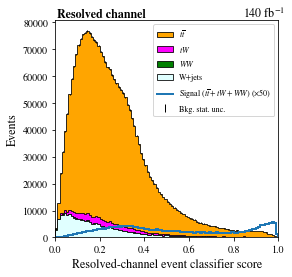

In [53]:
basesel_expr = "(d.lep_pt > 0)"
# basesel_expr = "(d.lep_pt > 0) & (~d.pass_fj_selection)"

# flavour cut
basesel_expr += " & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)"

# DNN cut
# basesel_expr += " & (d.score_is_w_matched > 0.85)"

# special cut
# basesel_expr = "(ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2, axis=1) == 3) & (ak.sum(d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) == 1)"

# varname = "tlep_cand_mass"; varlabel=""; do_plotting = True
varname = "evt_dnn_score"; varlabel="Resolved-channel event classifier score"; do_plotting = True
# varname = "evt_dnn_score_high"; varlabel="Resolved-channel event classifier score"; do_plotting = True
# varname = "n_cleanjet"; varlabel=""; do_plotting = True

# aux weights
actural_lumi = 140. # fb-1

categories_to_draw = [
    "bkg_wjets", "bkg_wwsl", "bkg_twsl", "bkg_ttbarsl",
    "sig_total"
    # "sig_ttbarsl", "sig_twsl", "sig_wwsl",
    ]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

from scipy.stats import chi2
def garwood_interval(N, alpha=0.317):
    lower_bound = 0 if N == 0 else chi2.ppf(alpha/2, 2*N) / 2
    upper_bound = chi2.ppf(1 - alpha/2, 2*(N+1)) / 2
    return lower_bound, upper_bound

def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
    def _fill_hist(input):
        vals, weights = input
        hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
        hist.fill(vals, weight=weights)
        return hist

    if nthreads == 1:
        return _fill_hist((var_array, weight_array))
    else:
        with ThreadPoolExecutor(nthreads) as pool:
            hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
        hist = reduce(add, hist)
        return hist

def _plotter(input):
    cname, sam = input
    print('Processing', cname, sam)
    # base selection
    d = dfc[(cname, sam)]
    d = d[eval(basesel_expr)]
    # fill histogram
    var_array = eval(varexpr)
    weight_array = np.ones(len(d))
    hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
    # yields within ... tbd
    yld = len(d[d.evt_dnn_score > 0.96])
    return hist, yld

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam] * (actural_lumi / 450.))
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam] * (actural_lumi / 450.)
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
print(
    f'**Total signal/bkg yield within 0.96 DNN score**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]),
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")]),
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plotting: stacked histogram
fig, ax = plt.subplots(figsize=(4, 4))
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
hep.histplot(
    [contents[cname] for cname in categories_to_draw if cname.startswith("bkg")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("bkg")],
    color=[config.categories[cname][3] for cname in categories_to_draw if cname.startswith("bkg")],
    histtype='fill', edgecolor='k', linewidth=0.8, stack=True,
)
# plotting: signals
hep.histplot(
    [contents[cname] * config.signal_mul_factor for cname in categories_to_draw if cname.startswith("sig")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] + f' (×{config.signal_mul_factor})' for cname in categories_to_draw if cname.startswith("sig")],
    linewidth=2,
)
# SM errorbar
## histogram tmpl uncertainty
# ax.errorbar(
#     (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
#     sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")]),
#     yerr=np.sqrt(sum([variances[cname] for cname in categories_to_draw if not cname.startswith("sig")])),
#     label='Bkg. unc.', color='black', linewidth=1, linestyle='none',
# )
## mimic the statistical uncertainty
bkg_bin_counts = sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")])
bkg_bin_err_lo, bkg_bin_err_hi = abs(bkg_bin_counts - np.array([garwood_interval(N) for N in bkg_bin_counts]).T)
ax.errorbar(
    (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
    bkg_bin_counts,
    yerr=[bkg_bin_err_lo, bkg_bin_err_hi],
    label='Bkg. stat. unc.', color='black', linewidth=1, linestyle='none',
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlabel(varlabel, fontsize=12)
ax.set_ylabel("Events", fontsize=12)
# ax.set_yscale("log")
ax.legend(prop={'size': 8}, loc='upper right', ncol=1, columnspacing=0.6, labelspacing=0.6)#, handletextpad=0.2, borderpad=0.5)
ax.text(0.01, 1.01, r"Resolved channel", fontsize=12, fontweight='bold', transform=ax.transAxes)
# ax.text(0.33, 1.01, r"(post-$D_{bc}$-cut)", fontsize=12, transform=ax.transAxes)
ax.text(0.84, 1.01, r"%d $\mathrm{fb}^{-1}$" % actural_lumi, fontsize=12, transform=ax.transAxes)
plt.savefig("paper_plots/dist_evtscore_resolved.pdf", bbox_inches='tight')
plt.show()

8.93882646325791 14.822037599012798


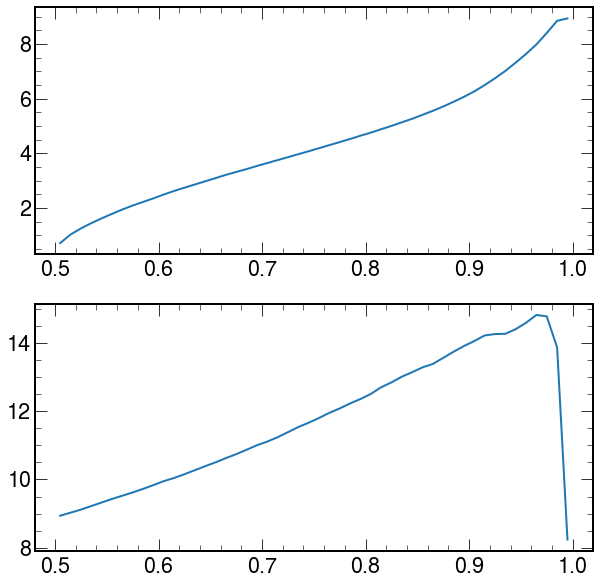

In [20]:
# significance curve
def signif(s, b):
    return np.sqrt(2*((s + b)*(np.log(1 + s/b)) - s))

hist_bkg = sum([contents[cname] for cname in categories_to_draw if cname.startswith("bkg")])
hist_sig = sum([contents[cname] for cname in categories_to_draw if cname.startswith("sig")])
x = hist.axes[0].centers
z_inv = signif(np.cumsum(hist_sig), np.cumsum(hist_bkg))
z = signif(np.cumsum(hist_sig[::-1])[::-1], np.cumsum(hist_bkg[::-1])[::-1])
# z_inv = np.nan_to_num(z_inv, nan=0)
# z = np.nan_to_num(z, nan=0)

fig, axs = plt.subplots(2, 1)
axs[0].plot(x, z_inv, label='Sig. (inv.)', linewidth=2)
axs[1].plot(x, z, label='Sig.', linewidth=2)
print(np.max(z_inv), np.max(z))

## Cutflow table

In [18]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories_cutflow = { # category name: (sample list, selection, label, color)
        "wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
    
        "ttbarsl_total": (["ttbarsl"], "~d.is_wcb", r"Bkg ($t_{bqq'}$)", "blue"),
        "twsl_total": (["twsl"], "~d.is_wcb", r"Bkg ($t_{bqq'}$)", "blue"),
        "wwsl_total": (["wwsl"], "~d.is_wcb", r"Bkg ($t_{bqq'}$)", "blue"),
        # signals
        "sig_total": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb", r"Sig ($t_{bqq'}$)", "blue"),
    },

    selections_cutflow = {
        "baseline": "(~d.pass_fj_selection)",
        "nbc3": "(~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)",
        "dnn": "(~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3) & (d.evt_dnn_score > 0.990)",
        # "baseline": "d.lep_pt > 0",
        # "nbc3": "(ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)",
        # "dnn": "(ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3) & (d.evt_dnn_score > 0.986)",
    }
)

In [16]:
dfc = {}
for cname, (samlist, sel, label, color) in config.categories_cutflow.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [19]:
def float_format(x):
    x = float(format(x, '.1e'))
    if x % 1.0 == 0:
        return int(x)
    return x
    
for selname, sel in config.selections_cutflow.items():
    # print(selname)
    for cname, (samlist, _, _, _) in config.categories_cutflow.items():
        count = 0
        for sam in samlist:
            d = dfc[(cname, sam)]
            count += len(d[eval(sel)]) * weights[sam] * (140 / 450)# * (len(df0[sam]) / len(df[sam]))
        print(float_format(count), end='\t')
    print()

18000000	8600000	440000	140000	7500	
170000	1800000	56000	1900	4000	
0	6.6	0	0	9.6	


## Flavour-tagging uncertainties & Fit templates

In [8]:
# Assign the SF value from the SF tables depending on truth label, ftag region, and pT
ftag_sf = {
    "bjet": {
        "pt_edges": [20, 30, 40, 60, 100, 175, 250],
        "B1": [0.07, 0.04, 0.03, 0.01, 0.01, 0.02, 0.03],
        "B2": [0.07, 0.04, 0.03, 0.02, 0.03, 0.04, 0.08],
        "C1": [0.06, 0.03, 0.02, 0.02, 0.03, 0.06, 0.14],
        "C2": [0.05, 0.03, 0.01, 0.01, 0.02, 0.04, 0.10],
        "N":  [0.20, 0.12, 0.08, 0.05, 0.07, 0.08, 0.13],
    },
    "cjet": {
        "pt_edges": [20, 40, 65, 140],
        "B1": [0.10, 0.08, 0.08, 0.08],
        "B2": [0.10, 0.05, 0.05, 0.06],
        "C1": [0.10, 0.04, 0.04, 0.04],
        "C2": [0.07, 0.07, 0.06, 0.06],
        "N":  [0.07, 0.04, 0.04, 0.04],
    },
    "ljet": {
        "pt_edges": [20, 50, 100, 150],
        "B1": [0.23, 0.22, 0.24, 0.20],
        "B2": [0.22, 0.22, 0.25, 0.20],
        "C1": [0.12, 0.12, 0.13, 0.12],
        "C2": [0.13, 0.13, 0.13, 0.12],
        "N":  [0.0035, 0.0025, 0.0025, 0.0022],
    },
}
for sam in df:
    d = df[sam]

    # flatten the pT array
    jet_pt_flat = ak.flatten(d.jet_pt)
    counts = ak.num(d.jet_pt)

    # initiate SFs
    sf = np.zeros(len(jet_pt_flat))

    for flv in ["bjet", "cjet", "ljet"]:
        if flv == "bjet":
            truth_flag = (d.jet_flavor == 5)
        elif flv == "cjet":
            truth_flag = (d.jet_flavor == 4)
        else:
            truth_flag = (d.jet_flavor != 5) & (d.jet_flavor != 4)

        # for each truth flavour, assign the corresponding SF from the 5 regions and the corresponding SF table
        for ch in ["B1", "B2", "C1", "C2", "N"]:
            _idx = np.searchsorted(ftag_sf[flv]["pt_edges"], np.maximum(ak.to_numpy(jet_pt_flat), 20+1e-8)) - 1
            _sf = np.array(ftag_sf[flv][ch])[_idx]
            flag_flat = ak.flatten(truth_flag * getattr(d, f"jet_ftag_{ch}"))
            sf = sf + _sf * flag_flat

    df[sam]['jet_ftag_SF'] = ak.unflatten(sf, counts)

In [9]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [25]:
# ## calculate event yields

# basesel_expr = "(d.lep_pt > 0)"

# target_flv = "cjet"

# target_flv_expr = {
#     "bjet": "d.jet_flavor == 5",
#     "cjet": "d.jet_flavor == 4",
#     "ljet": "(d.jet_flavor != 5) & (d.jet_flavor != 4)",
# }

# yld, yld_up, yld_dn = {}, {}, {}
# yld_tot, yld_tot_up, yld_tot_dn = {}, {}, {}
# for cname, (samlist, sel, label, color) in config.categories.items():
#     yld[cname], yld_up[cname], yld_dn[cname] = 0, 0, 0
#     yld_tot[cname], yld_tot_up[cname], yld_tot_dn[cname] = 0, 0, 0
#     for sam in samlist:
#         d = dfc[(cname, sam)]
#         d = d[eval(basesel_expr)]

#         # calculate weights by only considering the target flavour
#         cleanjet_flag = (d.jet_p4.deltaR(d.lep_p4) > 0.4)
#         truth_flag = eval(target_flv_expr[target_flv])
#         wgt_up = ak.prod((1 + d.jet_ftag_SF)[cleanjet_flag & truth_flag], axis=1)
#         wgt_dn = ak.prod((1 - d.jet_ftag_SF)[cleanjet_flag & truth_flag], axis=1)

#         yld_tot[cname] += len(d) * weights[sam]
#         yld_tot_up[cname] += ak.sum(wgt_up) * weights[sam]
#         yld_tot_dn[cname] += ak.sum(wgt_dn) * weights[sam]

#         yld[cname] += len(d[d.evt_dnn_score > 0.96]) * weights[sam]
#         yld_up[cname] += ak.sum(wgt_up[d.evt_dnn_score > 0.96]) * weights[sam]
#         yld_dn[cname] += ak.sum(wgt_dn[d.evt_dnn_score > 0.96]) * weights[sam]

# print(
#     f'**Total signal/bkg yield within 0.96 DNN score**',
#     sum([yld[cname] for cname in config.categories if cname.startswith("sig")]),
#     sum([yld[cname] for cname in config.categories if cname.startswith("bkg")]),
# )
# print(
#     f'**Up:**',
#     sum([yld_up[cname] for cname in config.categories if cname.startswith("sig")]) / sum([yld[cname] for cname in config.categories if cname.startswith("sig")])- 1,
#     sum([yld_up[cname] for cname in config.categories if cname.startswith("bkg")]) / sum([yld[cname] for cname in config.categories if cname.startswith("bkg")])- 1,
# )
# print(
#     f'**Up:**',
#     sum([yld_up[cname] for cname in config.categories if cname.startswith("sig")]) / \
#         sum([yld_tot_up[cname] for cname in config.categories if cname.startswith("sig")]) * \
#         sum([yld_tot[cname] for cname in config.categories if cname.startswith("sig")]) / \
#         sum([yld[cname] for cname in config.categories if cname.startswith("sig")]) - 1,
#     sum([yld_up[cname] for cname in config.categories if cname.startswith("bkg")]) / \
#         sum([yld_tot_up[cname] for cname in config.categories if cname.startswith("bkg")]) * \
#         sum([yld_tot[cname] for cname in config.categories if cname.startswith("bkg")]) / \
#         sum([yld[cname] for cname in config.categories if cname.startswith("bkg")]) - 1,
# )
# # print(
# #     f'**Down:**',
# #     sum([yld_dn[cname] for cname in config.categories if cname.startswith("sig")]) / sum([yld[cname] for cname in config.categories if cname.startswith("sig")])- 1,
# #     sum([yld_dn[cname] for cname in config.categories if cname.startswith("bkg")]) / sum([yld[cname] for cname in config.categories if cname.startswith("bkg")])- 1,
# # )

In [10]:
# make event DNN template
## note: you should decide whether to remove events passing fj trigger!!!  & (~d.pass_fj_selection)

def make_flv_variation_template(target_flv, target_region, target_variation):

    assert target_flv in ["bjet", "cjet", "ljet"]
    assert target_region in ["B1", "B2", "C1", "C2", "N"]
    assert target_variation in ["up", "down", "nominal"]
    print(f"Making template for {target_flv} in {target_region} with {target_variation} variation")

    basesel_expr = "(d.lep_pt > 0)"
    basesel_expr += " & (~d.pass_fj_selection)"
    # flavour cut
    basesel_expr += " & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)"
    varname = "evt_dnn_score_0p9_1_1000"; do_plotting = True

    ############
    # basesel_expr = "(ak.sum(d.obj_is_cleanjet_ftag_B1, axis=1) == 3) & (ak.sum(d.obj_is_cleanjet_ftag_C1, axis=1) == 1)"
    # varname = "n_looseljet"; do_plotting = True

    categories_to_draw = [
        "bkg_wjets", "bkg_ttbarsl", "bkg_twsl", "bkg_wwsl",
        "sig_ttbarsl", "sig_twsl", "sig_wwsl",
        ]

    varexpr, varaxis = config.variables[varname]
    print("Selection:", basesel_expr)
    print("Variable:", varexpr)

    def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
        def _fill_hist(input):
            vals, weights = input
            hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
            hist.fill(vals, weight=weights)
            return hist

        if nthreads == 1:
            return _fill_hist((var_array, weight_array))
        else:
            with ThreadPoolExecutor(nthreads) as pool:
                hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
            hist = reduce(add, hist)
            return hist

    def _plotter(input):
        cname, sam = input
        # print('Processing', cname, sam)
        # base selection
        d = dfc[(cname, sam)]
        d = d[eval(basesel_expr)]
        # fill histogram
        var_array = eval(varexpr)

        ##### custom weight array #####
        target_flv_map = {
            "bjet": "d.jet_flavor == 5",
            "cjet": "d.jet_flavor == 4",
            "ljet": "(d.jet_flavor != 5) & (d.jet_flavor != 4)",
        }
        target_region_map = {
            'B1': "d.jet_ftag_B1",
            'B2': "d.jet_ftag_B2",
            'C1': "d.jet_ftag_C1",
            'C2': "d.jet_ftag_C2",
            'N': "d.jet_ftag_N",
        }

        cleanjet_flag = (d.jet_p4.deltaR(d.lep_p4) > 0.4) & (d.jet_pt > 25) # reminder of pt > 25 cut!
        flv_flag = eval(target_flv_map[target_flv])
        region_flag = eval(target_region_map[target_region])

        if target_variation == 'up':
            weight_array = ak.prod((1 + d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        elif target_variation == 'down':
            weight_array = ak.prod((1 - d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        else:
            weight_array = np.ones(len(d))
        ##### end custom weight array #####

        hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
        # yields within ... tbd
        yld = len(d[d.evt_dnn_score > 0.96])
        return hist, yld

    # generate inputs to send into concurrent plotter
    zipped_input = []
    for cname, (samlist, sel, label, color) in config.categories.items():
        for sam in samlist:
            zipped_input.append((cname, sam))

    # plotting
    if do_plotting:
        with ThreadPoolExecutor(2) as pool:
            results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

    # retreive and group results for each category
    contents, variances, contents_mass_win = {}, {}, {}
    hists = {}
    for cname, (samlist, sel, label, color) in config.categories.items():
        _hists = []
        contents_mass_win[cname] = 0
        for sam in samlist:
            _hists.append(results[(cname, sam)][0] * weights[sam])
            contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam]
        hists[cname] = sum(_hists)
        contents[cname], variances[cname] = hists[cname].view().value, hists[cname].view().variance
        # print(cname, round(contents_mass_win[cname], 1))

    templs = {}
    for cm in config.categories_merged:
        templs[cm] = sum([hists[cname] for cname in config.categories_merged[cm]])

    return templs

templs_summary = {}
for target_flv in ["bjet", "cjet", "ljet"]:
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        for target_variation in ["up", "down"]:
            templs_summary[f"{target_flv}_{target_region}_{target_variation}"] = make_flv_variation_template(target_flv, target_region, target_variation)
templs_summary["nom"] = make_flv_variation_template("bjet", "B1", "nominal")

Making template for bjet in B1 with up variation
Selection: (d.lep_pt > 0) & (~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)
Variable: d.evt_dnn_score


Making template for bjet in B1 with down variation
Selection: (d.lep_pt > 0) & (~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)
Variable: d.evt_dnn_score
Making template for bjet in B2 with up variation
Selection: (d.lep_pt > 0) & (~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)
Variable: d.evt_dnn_score
Making template for bjet in B2 with down variation
Selection: (d.lep_pt > 0) & (~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_ftag_C2, axis=1) >= 3)
Variable: d.evt_dnn_score
Making template for bjet in C1 with up variation
Selection: (d.lep_pt > 0) & (~d.pass_fj_selection) & (ak.sum(d.obj_is_cleanjet_ftag_B1 | d.obj_is_cleanjet_ftag_B2 | d.obj_is_cleanjet_ftag_C1 | d.obj_is_cleanjet_f

In [12]:
import pickle
# 2025.02.13: further: require n_b/c jets >=3, use 1000 bins
# with open("pickles/wcb_rsvana_templ_newsample_v0213.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
# with open("pickles/wcb_rsvana_templ_newsample_v0213_nbc3_dnnbin0p9-1-1000.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
# with open("pickles/wcb_rsvana_templ_newsample_v0213_nbc3_dnnbin0p9-1-1000_excludefj.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
# with open("pickles/wcb_rsvana_templ_newsample_v0213_nbc3_dnnbin0p9-1-1000_pt25_olddnnredefine.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
# with open("pickles/wcb_rsvana_templ_v0213_simplecut.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)

# 2025.02.13: switch to obj jet pt > 25 (now default is dnnbin0p9-1-1000)
# with open("pickles/wcb_rsvana_templ_newsample_v0216.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
with open("pickles/wcb_rsvana_templ_newsample_v0216_nbc3_excludefj.pkl", "wb") as f:
    pickle.dump(templs_summary, f)


# with open("pickles/wcb_rsvana_templ_newsample_v0216_nbc3.pkl", "rb") as f:
#     templs_summary = pickle.load(f)
with open("pickles/wcb_rsvana_templ_newsample_v0216.pkl", "rb") as f:
    templs_summary_orig = pickle.load(f)

### Write template original

In [31]:
# ## write templates
# filedir = './datacards/resolved'
# aux_weight_scale = 3000. / 450 # for HL-LHC
# # aux_weight_scale = 1.

# import copy
# _templs = copy.deepcopy(templs_summary) ## important!

# hist_out = {}
# for cm in config.categories_merged:
#     hist_out[cm] = _templs["nom"][cm]

# for target_flv in ["bjet", "cjet", "ljet"]:
#     for target_region in ["B1", "B2", "C1", "C2", "N"]:
#         for target_variation in ["up", "down"]:
#             _variation = "Up" if target_variation == "up" else "Down"
#             for cm in config.categories_merged:
#                 n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
#                 hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm]
#                 # make sure the total yields doesn't change
#                 hist_out[n].view().value *= sum(hist_out[cm].view().value) / sum(hist_out[n].view().value)
#                 hist_out[n].view().variance *= (sum(hist_out[cm].view().value) / sum(hist_out[n].view().value))**2

# hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

# # aux weight scale
# for n in hist_out:
#     hist_out[n].view().value *= aux_weight_scale
#     hist_out[n].view().variance *= aux_weight_scale**2

# # rebin the DNN score
# # === old setup ===
# # for n in hist_out:
# #     # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
# #     hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
# #     hist_out[n].view().variance *= 0
# # ======
# def rebin_hist_var_width(orig_hist, new_axis):
#     new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
#     for i in range(orig_hist.axes[0].size):
#         bin_center = orig_hist.axes[0].centers[i]
#         if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
#             new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
#             new_hist.view().value[new_idx] += orig_hist.view().value[i]
#             new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
#     return new_hist

# for n in hist_out:
#     # hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Regular(10, 0.6, 1)) # 0.112
#     # hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Regular(15, 0.4, 1)) # 0.082
#     # hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Regular(20, 0.2, 1)) # 0.058
#     # hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Regular(25, 0., 1))
#     # hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.0]))
#     hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0.96, 1]))
#     # hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0, 1.0]))
#     hist_out[n].view().variance *= 0

# print('Apply aux weight scale:', aux_weight_scale)
# print(hist_out['data_obs'].values().sum())

# with uproot.recreate(f'{filedir}/input_SR.root') as fw:
#     for n in hist_out:
#         fw[n] = hist_out[n]

# lines = open(f'{filedir}/datacard.txt').readlines()
# for i, line in enumerate(lines):
#     if line.startswith('observation'):
#         lines[i] = f'observation {hist_out["data_obs"].values().sum()}\n'
# with open(f'{filedir}/datacard.txt', 'w') as f:
#     f.writelines(lines)

Apply aux weight scale: 6.666666666666667
19018402.584994726


### Write template new (template has flavour cut applied..)

In [85]:
## new impl. for templs adding a flavour tagger cut

## write templates
filedir = './datacards/resolved'
aux_weight_scale = 3000. / 450 # for HL-LHC
# aux_weight_scale = 1.
aux_flavor_strength = 0.5

import copy
_templs = copy.deepcopy(templs_summary) ## important!
_templs0 = copy.deepcopy(templs_summary_orig) ## important!

hist_out = {}
for cm in config.categories_merged:
    hist_out[cm] = _templs["nom"][cm]

for target_flv in ["bjet", "cjet", "ljet"]:
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        for target_variation in ["up", "down"]:
            _variation = "Up" if target_variation == "up" else "Down"
            # get the inclusive non-flavour-cut template's total yield
            nevt_tot_nom = sum(_templs0["nom"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
            nevt_tot_flv = sum(_templs0[f"{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
            fac =  nevt_tot_nom / nevt_tot_flv

            for cm in config.categories_merged:
                n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm]
                # make sure the total yields doesn't change (use non-flavour-cut template)
                hist_out[n].view().value *= fac
                hist_out[n].view().variance *= fac**2

hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

# aux weight scale
for n in hist_out:
    hist_out[n].view().value *= aux_weight_scale
    hist_out[n].view().variance *= aux_weight_scale**2

# rebin the DNN score
# === old setup ===
# for n in hist_out:
#     # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
#     hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
#     hist_out[n].view().variance *= 0
# ======
def rebin_hist_var_width(orig_hist, new_axis):
    new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
    for i in range(orig_hist.axes[0].size):
        bin_center = orig_hist.axes[0].centers[i]
        if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
            new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
            new_hist.view().value[new_idx] += orig_hist.view().value[i]
            new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
    return new_hist

for n in hist_out:
    hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0.986, 1])) # 0.990-0.992 all optimal..; for stregth=0.5, 0.986; for stregth=0.2, 0.983
    hist_out[n].view().value = np.maximum(hist_out[n].view().value, 1e-3)
    hist_out[n].view().variance *= 0

import re
for n in hist_out:
    if 'ftag' in n:
        hist_out[n].view().value = hist_out[n].view().value * aux_flavor_strength + hist_out[re.sub(r"(_ftag_.*)", "", n)].view().value * (1 - aux_flavor_strength)

print('Apply aux weight scale:', aux_weight_scale)
print(hist_out['data_obs'].values().sum())

with uproot.recreate(f'{filedir}/input_SR.root') as fw:
    for n in hist_out:
        fw[n] = hist_out[n]

lines = open(f'{filedir}/datacard.txt').readlines()
for i, line in enumerate(lines):
    if line.startswith('observation'):
        lines[i] = f'observation {hist_out["data_obs"].values().sum()}\n'
with open(f'{filedir}/datacard.txt', 'w') as f:
    f.writelines(lines)

Apply aux weight scale: 6.666666666666667
4458.556960985556


In [65]:
val_nom = sum([hist_out[n].values().sum() for n in hist_out if n.startswith('bkg_allwhad') and 'ftag' not in n])
print(val_nom)
array = []
for target_flv in ["bjet", "cjet", "ljet"]:
    _array = []
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        val_up = sum([hist_out[n].values().sum() for n in hist_out if n.startswith('bkg_allwhad') and n.endswith(f'{target_flv}_{target_region}Up')])
        _array.append((val_up/val_nom - 1)*100)
        # print(target_flv, target_region, val_up, val_nom)
    array.append(_array)
print(array)

3638.92408336939
[[4.3154339599616565, -0.005879668376895797, 0.19968639286453982, 0.12559227663244688, -0.4927207706913017], [2.8992095426248365, 0.09828538721046165, 2.2622328781211065, -0.08258132263225804, -0.9644319235892485], [1.7963981015266084, 0.0636752310981814, 0.3256976078513274, 0.03286323184086282, -0.7065341867258268]]


/tmp/ipykernel_2700353/4076031780.py:21: RuntimeWarning: invalid value encountered in divide
  [_templs[k]['bkg_allwhad'].values() / (_templs['nom']['bkg_allwhad'].values()) for k in keys],


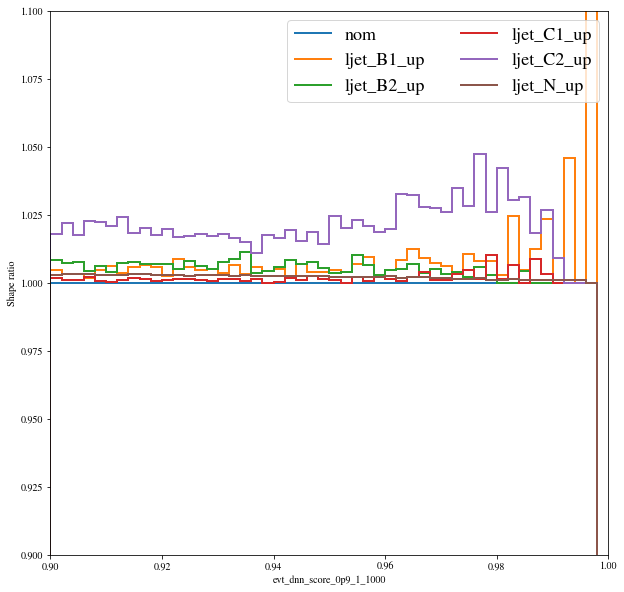

In [67]:
## (optional) checks
import copy
_templs = copy.deepcopy(templs_summary_orig)

# rebin
for hname in _templs.keys():
    for sam in _templs[hname]:
        _templs[hname][sam] = _templs[hname][sam][::bh.rebin(20)]

flv = 'ljet'

keys = ["nom"] + [k for k in _templs if (k.startswith(flv) and k.endswith("up"))]

# plotting: stacked histogram
fig, ax = plt.subplots(figsize=(10, 10))
varname = "evt_dnn_score_0p9_1_1000"
varexpr, varaxis = config.variables[varname]
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())[::bh.rebin(20)]
hep.histplot(
    # [_templs[k]['bkg_allwhad'].values() / sum(_templs[k]['bkg_allwhad'].values()) / (_templs['nom']['bkg_allwhad'].values() / sum(_templs['nom']['bkg_allwhad'].values())) for k in keys],
    [_templs[k]['bkg_allwhad'].values() / (_templs['nom']['bkg_allwhad'].values()) for k in keys],
    bins=hist.axes[0].edges,
    label=keys,
    linewidth=2,
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlim(0.9, 1)
ax.set_ylim(0.9, 1.1)
ax.set_xlabel(varname)
ax.set_ylabel("Shape ratio")
# ax.set_yscale("log")
ax.legend(prop={'size': 18}, loc='upper right', ncol=2)
plt.show()

8.88781586395878 14.227648338133012


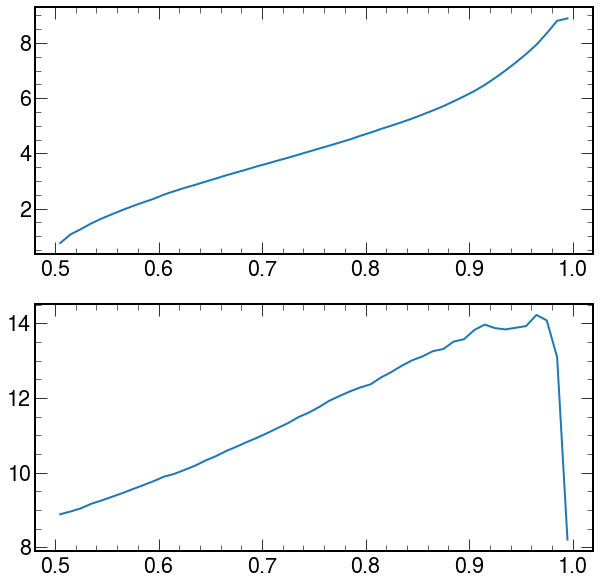